In [2]:
import copy
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import re
import pickle
from twinning import twinning
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBClassifier


from gplearn.genetic import SymbolicClassifier

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_validate, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, \
    classification_report, f1_score, precision_score, recall_score, roc_curve, roc_auc_score 

from b3db_kc.utils import calculate_cns_mpo_score_wager_2010, calculate_balanced_permeability_index_weiss_2024

def pr_auc_score(y_true, probas_pred):
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=probas_pred)
    return auc(recall, precision)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[09:36:53] Initializing Normalizer


In [3]:
df_b3db_kc = pd.read_csv("b3db_kc_split_descriptors.tsv", sep="\t")
df_b3db_kc['BBB_numeric'] = df_b3db_kc['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
df_train = df_b3db_kc[df_b3db_kc.split == "training"].copy().reset_index(drop=1)
df_test = df_b3db_kc[df_b3db_kc.split == "test"].copy().reset_index(drop=1)
print(f"Read {len(df_b3db_kc)} records, {len(df_train)} in training, and {len(df_test)} in test splits.")


df_train_features = df_train.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split"]) #, "murcko_scaffold_grouped"])
df_train_features_desc2D_chemaxon = df_train_features[[c for c in list(df_train_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_train_features_ecfp_count = df_train_features[[c for c in list(df_train_features) if c.startswith("ecfp")]]
df_train_features_maccs = df_train_features[[c for c in list(df_train_features) if c.startswith("maccs")]]

Read 3322 records, 2677 in training, and 645 in test splits.


In [4]:
def get_correlated_features(_df, feature, threshold=0.9):
    cor_mtx = _df.corr()
    correlated = []
    for c in list(cor_mtx.columns):
        if c != feature:
            c_a = abs(cor_mtx.loc[feature, c])
            if c_a > threshold:
                # print(c, feature, c_a)
                correlated.append(c)
    return correlated          

def get_feature_rank_mutual_information(X, y):
    mutual_info_scores = mutual_info_classif(X, y, random_state=42)
    mutual_info_scores_series = pd.Series(mutual_info_scores, index=X.columns)
    return mutual_info_scores_series.sort_values(ascending=False)
    
def get_feature_rank_xgboost_classification(X, y):
    model = XGBClassifier(random_state=42)
    model.fit(X, y)
    return pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# def get_feature_rank_random_forest_classification(X, y, n_features_to_select=None):
#     model = RandomForestClassifier(random_state=42)
#     #rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) # None implies half the features get selected
#     #rfe.fit(X, y)
#     # return pd.Series(rfe.ranking_, index=X.columns)
#     sfs = SequentialFeatureSelector(estimator=model, n_jobs=-1, n_features_to_select=n_features_to_select)
#     sfs.fit(X, y)
#     z = pd.Series(sfs.get_support(), index=X.columns)
#     return z[z == True]
#     
# def get_feature_rank_logistic_regression(X, y, n_features_to_select=None):
#     model = LogisticRegression(random_state=42, max_iter=1000)
#     #rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) # None implies half the features get selected
#     #rfe.fit(X, y)
#     # return pd.Series(rfe.ranking_, index=X.columns)
#     sfs = SequentialFeatureSelector(estimator=model, n_jobs=-1, n_features_to_select=n_features_to_select)
#     sfs.fit(X, y)
#     z = pd.Series(sfs.get_support(), index=X.columns)
#     return z[z == True]


# def get_filtered_ranked_features(X, y):
#     """
#     This method first extracts the features that are both present in top 50% based on both mutual information and top performers under XGBoost classification. It then ranks the remaining features using Recursive Feature Elimination wrapper using Random Forest model.
#     
#     This method relies on both boosted algorithms that performed well during the train / test split selection.
#     """
#     _n_mut_inf_xgboost_feats = int(len(list(X)) / 2)
#     _fs_mut_inf = get_feature_rank_mutual_information(X, y)
#     _fs_xgboost = get_feature_rank_xgboost_classification(X, y)
#     _s_fs = set(_fs_mut_inf.index[:_n_mut_inf_xgboost_feats]) & set(_fs_xgboost.index[:_n_mut_inf_xgboost_feats])
#     fs_ranking = get_feature_rank_random_forest_classification(X[[f for f in list(X) if f in _s_fs]], y, n_features_to_select=1)
#     return fs_ranking



In [5]:
CNS_MPO_FEATURES = ["desc2D_TPSA", "desc2D_MolWt", "desc2D_NumHDonors", "chemaxon_logp", "chemaxon_logd", "chemaxon_pka_b"]
CORRELATION_THRESHOLD = 0.8

_selected = CNS_MPO_FEATURES + ["desc2D_NumHAcceptors", "desc2D_HeavyAtomCount"]
_correlated = set()
for _f in _selected + [c for c in get_feature_rank_mutual_information(df_train_features_desc2D_chemaxon, df_train["BBB_numeric"]).index if c not in _selected]:    
    if _f not in _correlated:
        if _f not in _selected:
            _selected.append(_f)
        _correlated = _correlated | set(get_correlated_features(df_train_features_desc2D_chemaxon, _f, threshold=CORRELATION_THRESHOLD))
df_train_features_desc2D_chemaxon_filtered = df_train_features_desc2D_chemaxon[_selected]
print(f"Removed {len(list(df_train_features_desc2D_chemaxon)) - len(list(df_train_features_desc2D_chemaxon_filtered))} desc2D+ChemAxon correlated features (threshold: {CORRELATION_THRESHOLD}), {len(list(df_train_features_desc2D_chemaxon_filtered))} remaining")
#mutget_feature_rank_mutual_information(df_train_features_desc2D_chemaxon, df_train["BBB_numeric"])

Removed 60 desc2D+ChemAxon correlated features (threshold: 0.8), 151 remaining


In [6]:
SIMPLE_FILTERED_FEATURES = [
    'desc2D_TPSA',
    'desc2D_NumHDonors',
    'desc2D_MolWt',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_qed',
    'desc2D_MinEStateIndex',
    'desc2D_HallKierAlpha',
    'desc2D_Kappa3',
    'desc2D_Ipc',
    'desc2D_FractionCSP3',
    'desc2D_MinAbsEStateIndex',
    'desc2D_MaxAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_NumAliphaticHeterocycles',
    'desc2D_NumSaturatedCarbocycles',
    'desc2D_BalabanJ',
    'desc2D_NumSpiroAtoms',
    'desc2D_NumAtomStereoCenters',
    'desc2D_NumBridgeheadAtoms',
    'desc2D_NumUnspecifiedAtomStereoCenters',
    'desc2D_NumRadicalElectrons',
    'desc2D_SPS',
]
EXTENDED_FILTERED_FEATURES = SIMPLE_FILTERED_FEATURES + [
    'desc2D_SMR_VSA1',
    'desc2D_SMR_VSA10',
    'desc2D_SlogP_VSA2',
    'desc2D_PEOE_VSA10',
    'desc2D_VSA_EState3',
    'desc2D_SlogP_VSA3',
    'desc2D_SMR_VSA5',
    'desc2D_EState_VSA4',
    'desc2D_EState_VSA2',
    'desc2D_PEOE_VSA8',
    'desc2D_VSA_EState2',
    'desc2D_EState_VSA9',
    'desc2D_PEOE_VSA9',
    'desc2D_PEOE_VSA6',
    'desc2D_EState_VSA3',
    'desc2D_EState_VSA8',
    'desc2D_SMR_VSA6',
    'desc2D_SlogP_VSA1',
    'desc2D_EState_VSA5',
    'desc2D_VSA_EState9',
    'desc2D_EState_VSA6',
    'desc2D_VSA_EState5',
    'desc2D_PEOE_VSA7',
    'desc2D_fr_COO2',
    'desc2D_VSA_EState4',
    'desc2D_SMR_VSA3',
    'desc2D_VSA_EState1',
    'desc2D_VSA_EState7',
    'desc2D_PEOE_VSA14',
    'desc2D_SMR_VSA4',
    'desc2D_PEOE_VSA11',
    'desc2D_PEOE_VSA3',
    'desc2D_SlogP_VSA10',
    'desc2D_fr_halogen',
    'desc2D_PEOE_VSA13',
    'desc2D_Alerts',
    'desc2D_EState_VSA7',
    'desc2D_PEOE_VSA4',
    'desc2D_PEOE_VSA5',
    'desc2D_fr_sulfide',
    'desc2D_fr_para_hydroxylation',
    'desc2D_PEOE_VSA12',
    'desc2D_fr_ketone_Topliss',
    'desc2D_fr_Ar_OH',
    'desc2D_fr_N_O',
    'desc2D_fr_allylic_oxid',
    'desc2D_fr_lactam',
    'desc2D_fr_aldehyde',
    'desc2D_VSA_EState8',
    'desc2D_fr_sulfone',
    'desc2D_fr_Al_OH_noTert',
    'desc2D_fr_epoxide',
    'desc2D_fr_thiazole',
    'desc2D_SlogP_VSA8',
    'desc2D_SlogP_VSA11',
    'desc2D_fr_NH1',
    'desc2D_EState_VSA11',
    'desc2D_fr_NH2',
    'desc2D_fr_pyridine',
    'desc2D_fr_quatN',
    'desc2D_fr_azo',
    'desc2D_fr_isothiocyan',
    'desc2D_fr_nitro_arom_nonortho',
    'desc2D_fr_Ndealkylation2',
    'desc2D_fr_barbitur',
    'desc2D_fr_sulfonamd',
    'desc2D_fr_nitroso',
    'desc2D_fr_methoxy',
    'desc2D_fr_aniline',
    'desc2D_fr_urea',
    'desc2D_fr_diazo',
    'desc2D_fr_phos_ester',
    'desc2D_fr_ether',
    'desc2D_fr_SH',
    'desc2D_fr_aryl_methyl',
    'desc2D_fr_isocyan',
    'desc2D_fr_prisulfonamd',
    'desc2D_fr_azide',
    'desc2D_SlogP_VSA9',
    'desc2D_fr_piperdine',
    'desc2D_fr_imidazole',
    'desc2D_fr_priamide',
    'desc2D_fr_ArN',
    'desc2D_fr_amidine',
    'desc2D_fr_Ndealkylation1',
    'desc2D_fr_oxime',
    'desc2D_fr_morpholine',
    'desc2D_fr_benzodiazepine',
    'desc2D_fr_Imine',
    'desc2D_fr_guanido',
    'desc2D_fr_alkyl_carbamate',
    'desc2D_fr_bicyclic',
    'desc2D_fr_tetrazole',
    'desc2D_fr_dihydropyridine',
    'desc2D_fr_ester',
    'desc2D_fr_unbrch_alkane',
    'desc2D_SMR_VSA8',
    'desc2D_fr_thiophene',
    'desc2D_SlogP_VSA7',
    'desc2D_fr_thiocyan',
    'desc2D_fr_nitro',
    'desc2D_fr_term_acetylene',
    'desc2D_fr_Ar_COO',
    'desc2D_fr_hdrzine',
    'desc2D_fr_hdrzone',
    'desc2D_fr_piperzine',
    'desc2D_fr_NH0',
    'desc2D_fr_HOCCN',
    'desc2D_fr_lactone',
    'desc2D_fr_C_S',
    'desc2D_fr_oxazole',
    'desc2D_fr_furan',
    'desc2D_Chi4n',
    'desc2D_FpDensityMorgan1',
    'desc2D_FpDensityMorgan3',
    'desc2D_SMR_VSA7',
    'desc2D_SlogP_VSA12',
    'desc2D_SlogP_VSA4',
    'desc2D_fr_Ar_N',
    'desc2D_fr_Nhpyrrole',
    'desc2D_fr_amide',
    'desc2D_fr_imide',
    'desc2D_fr_nitrile',
]

In [6]:
# nmax=int(len(list(df_train_features)) / 2)
# #nmax = 1000
# features_selection_mutual_information = get_feature_rank_mutual_information(df_train_features, df_train["BBB_numeric"])
# features_selection_xgboost_classification = get_feature_rank_xgboost_classification(df_train_features, df_train["BBB_numeric"])
# _s_features_m_inf_and_xgboost = set(features_selection_mutual_information.index[:nmax]) & set(features_selection_xgboost_classification.index[:nmax])
# #print(len(_s_features_m_inf_and_xgboost))
# features_rf_ranking = get_feature_rank_random_forest_classification(df_train_features[[f for f in list(df_train_features) if f in _s_features_m_inf_and_xgboost]], df_train["BBB_numeric"], n_features_to_select=1)

In [7]:
# get_filtered_ranked_features(df_train_features_ecfp_count, df_train["BBB_numeric"])
# get_feature_rank_xgboost_classification(df_train_features_maccs, df_train["BBB_numeric"])
#get_feature_rank_xgboost_classification(df_b3db_kc[[c for c in list(df_b3db_kc) if c.startswith("maccs")]], df_b3db_kc["BBB_numeric"])

In [8]:
# from molfeat.trans.fp import FPVecTransformer
# from utils import smiles_to_mol
# df_b3db_kc["mol"] = df_b3db_kc.smiles.apply(smiles_to_mol)
# transformer = FPVecTransformer(kind="maccs", dtype=float, n_jobs=16, verbose=True)  
# _df_desc = pd.DataFrame(transformer(df_b3db_kc["mol"]), columns=transformer.columns)
# get_feature_rank_xgboost_classification(_df_desc, df_b3db_kc["BBB_numeric"])
# df_b3db = pd.read_csv("B3DB/B3DB/B3DB_classification.tsv", sep="\t")
# df_b3db["mol"] = df_b3db.SMILES.apply(smiles_to_mol)
# df_b3db['BBB_numeric'] = df_b3db['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
# _df_desc_b3db = pd.DataFrame(transformer(df_b3db["mol"]), columns=transformer.columns)
# get_feature_rank_xgboost_classification(_df_desc_b3db, df_b3db["BBB_numeric"])

In [7]:
df_test_features = df_test.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split", "murcko_scaffold_grouped"])
df_test_features_desc2D_chemaxon = df_test_features[[c for c in list(df_test_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_test_features_ecfp_count = df_test_features[[c for c in list(df_test_features) if c.startswith("ecfp")]]
df_test_features_maccs = df_test_features[[c for c in list(df_test_features) if c.startswith("maccs")]]


def evaluate_train(model, X_train, X_groups, y_train):
    return cross_validate(
        model, X_train, y_train,
        groups=X_groups,
        scoring=["roc_auc", "balanced_accuracy", "precision", "recall", "accuracy", "f1"],
        cv=StratifiedGroupKFold(5, shuffle=True, random_state=42),
        verbose=1,
        return_indices=True
    )


def evaluate_test(_model, X_test, y_test):
    y_pred = _model.predict(X_test)
    y_prob = _model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    return {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": pr_auc_score(y_test, y_prob),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
    }


def display_test_evaluation(_model, X_test, y_test):
    y_pred = _model.predict(X_test)
    y_prob = _model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = pr_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(_model.__class__.__name__)
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"PR AUC: {pr_auc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


In [9]:
print("Performance of logistic regression predictor (grouped CV on training dataset) based on a single feature")
_one_feature_regression_results = []
for f in list(df_train_features_desc2D_chemaxon_filtered):
    mod = LogisticRegression(random_state=42, max_iter=1000)
    _r = evaluate_train(mod, X_train=df_train[[f]], X_groups=df_train["murcko_scaffold_grouped"], y_train=df_train["BBB_numeric"])
    _r_m = {k.replace("test", "train") + "_avg": sum(v) / len(v) for k, v in _r.items() if "test" in k}
    _one_feature_regression_results.append({"feature": f} | _r_m)
df_one_feature_regression_results = pd.DataFrame(_one_feature_regression_results).sort_values("train_roc_auc_avg", ascending=False)

df_one_feature_regression_results

Performance of logistic regression predictor (grouped CV on training dataset) based on a single feature


,feature,train_roc_auc_avg,train_balanced_accuracy_avg,train_precision_avg,train_recall_avg,train_accuracy_avg,train_f1_avg
0,desc2D_TPSA,0.780373,0.692015,0.752748,0.890385,0.745097,0.815660
2,desc2D_NumHDonors,0.744593,0.657482,0.723312,0.933989,0.731710,0.815200
10,desc2D_SMR_VSA1,0.729650,0.636880,0.713326,0.902041,0.707925,0.796450
15,desc2D_VSA_EState3,0.719189,0.625774,0.706727,0.900365,0.700100,0.791875
16,desc2D_qed,0.715963,0.650291,0.725329,0.874150,0.710421,0.792749
...,...,...,...,...,...,...,...
56,desc2D_BalabanJ,0.482398,0.500000,0.634232,1.000000,0.634232,0.776084
71,desc2D_NumSaturatedCarbocycles,0.482283,0.500000,0.634232,1.000000,0.634232,0.776084
51,desc2D_VSA_EState8,0.477309,0.500000,0.634232,1.000000,0.634232,0.776084
61,desc2D_FractionCSP3,0.459801,0.500000,0.634232,1.000000,0.634232,0.776084


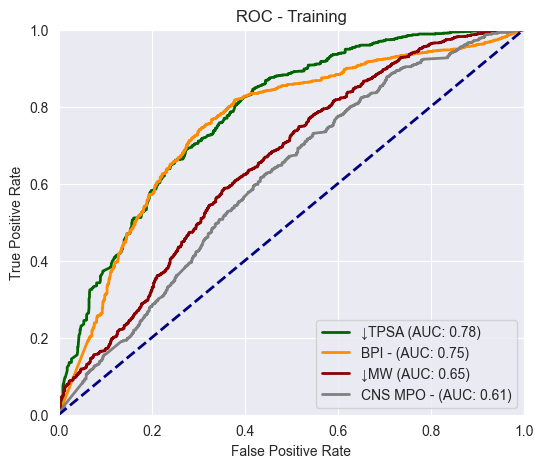

In [11]:
y_true = df_train["BBB_numeric"] 
plt.figure(figsize=(6, 5))

fpr_tpsa, tpr_tpsa, thresholds_tpsa = roc_curve(y_true, -df_train.desc2D_TPSA)
plt.plot(fpr_tpsa, tpr_tpsa, color='darkgreen', lw=2, label='↓TPSA (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_TPSA))

y_scores_bpi = df_train.apply(axis=1, func=lambda x: calculate_balanced_permeability_index_weiss_2024(
    c_log_d=x["chemaxon_logd"], 
    psa=x["desc2D_TPSA"] if x["desc2D_TPSA"] >= 3.24  else 3.24,  # 3.24 is the lowest value above 0. 
    hac=x["desc2D_HeavyAtomCount"]) 
).apply(lambda x: -5 if x < -5 else 5 if x > 5 else x)
fpr_bpi, tpr_bpi, thresholds_bpi = roc_curve(y_true, y_scores_bpi)
plt.plot(fpr_bpi, tpr_bpi, color='darkorange', lw=2, label='BPI - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_bpi))

# fpr_logd, tpr_logd, thresholds_logd = roc_curve(y_true, df_train.chemaxon_logd)
# plt.plot(fpr_logd, tpr_logd, color='teal', lw=2, label='LogD - (AUC: %.2f)' % roc_auc_score(y_true, df_train.chemaxon_logd))

fpr_mw, tpr_mw, thresholds_mw= roc_curve(y_true, -df_train.desc2D_MolWt)
plt.plot(fpr_mw, tpr_mw, color='darkred', lw=2, label='↓MW (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_MolWt))

y_scores_cns_mpo = df_train.apply(axis=1, func=lambda x: calculate_cns_mpo_score_wager_2010(
    c_log_p=x.chemaxon_logp, 
    c_log_d=x.chemaxon_logd, 
    mw=x.desc2D_MolWt, 
    tpsa=x.desc2D_TPSA, 
    hbd=x.desc2D_NumHDonors, 
    pka=x.chemaxon_pka_b))  # Example scores from your function
fpr_cns_mpo, tpr_cns_mpo, thresholds_cns_mpo = roc_curve(y_true, y_scores_cns_mpo)
plt.plot(fpr_cns_mpo, tpr_cns_mpo, color='grey', lw=2, label='CNS MPO - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_cns_mpo))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Training')
plt.legend(loc="lower right")
plt.show()

In [12]:
_log_reg_res_cns_mpo = evaluate_train(LogisticRegression(random_state=42), pd.DataFrame([y_scores_cns_mpo]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
_r_cns_mpo = {k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res_cns_mpo.items() if "test" in k}
print(f"Best fit logistic regression based on CNS_MPO score, balanced accuracy: {_r_cns_mpo['train_balanced_accuracy']}, ROC AUC: {_r_cns_mpo['train_roc_auc']}")

_log_reg_res_bpi = evaluate_train(LogisticRegression(random_state=42), pd.DataFrame([y_scores_bpi]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
_r_bpi = {k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res_bpi.items() if "test" in k}
print(f"Best fit logistic regression based on BPI score, balanced accuracy: {_r_bpi['train_balanced_accuracy']}, ROC AUC: {_r_bpi['train_roc_auc']}")

Best fit logistic regression based on CNS_MPO score, balanced accuracy: 0.5621635691909026, ROC AUC: 0.6149901344636469
Best fit logistic regression based on BPI score, balanced accuracy: 0.6466406813596095, ROC AUC: 0.7537434370334288


In [23]:
print("""
Symbolic regression attempts to find an optimal equation to base the classification on. It utilised genetic programming to search the space of possible equations performing mutations and "survival of the fittest" selection at each epoch.
""")


symbolic_classifier = SymbolicClassifier(
    n_jobs=-1, 
    verbose=1, 
    random_state=0,
    population_size=20000,
    generations=10,
    tournament_size=50,
    class_weight="balanced",
    function_set=('add', 'sub', 'mul', 'div', "neg", "abs", "sqrt", "inv"),
    const_range=(-100, 100),
    parsimony_coefficient=0.0035,
    #stopping_criteria=0.01,
)

X = df_train_features[SIMPLE_FILTERED_FEATURES]
symbolic_classifier.fit(X, df_train["BBB_numeric"])

# Predict on the test set
y_pred = symbolic_classifier.predict(df_test[list(X)])
print("Balanced accuracy on train set:", balanced_accuracy_score(df_train["BBB_numeric"], symbolic_classifier.predict(X)))
print("Balanced accuracy on test set:", balanced_accuracy_score(df_test["BBB_numeric"], y_pred))

def _program_to_mapped(program, features):
    _p = str(program)
    _pm = ""
    prev_end = 0
    for v in re.finditer(r"(X\w*)", _p):
        _pm += _p[prev_end:v.start()]
        _pm += features[int(v.groups()[0].lstrip("X"))]
        prev_end = v.end()
    _pm += _p[prev_end:]
    return _pm
        
_program_to_mapped(symbolic_classifier._program, list(X))


Symbolic regression attempts to find an optimal equation to base the classification on. It utilised genetic programming to search the space of possible equations performing mutations and "survival of the fittest" selection at each epoch.



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

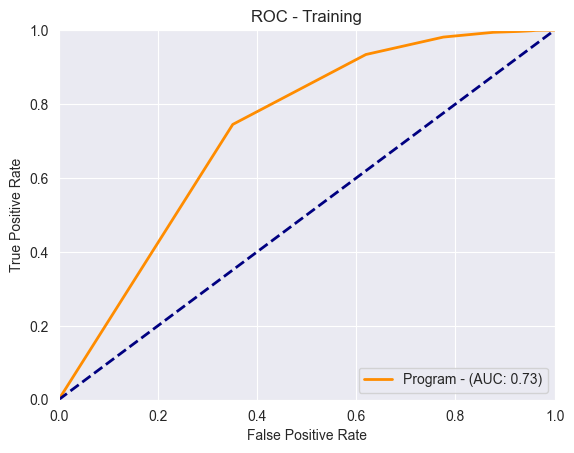

{'train_roc_auc': np.float64(0.729265637081755),
 'train_balanced_accuracy': np.float64(0.6978998493542657),
 'train_precision': np.float64(0.78672224290705),
 'train_recall': np.float64(0.7447302865902491),
 'train_accuracy': np.float64(0.7101785775344632),
 'train_f1': np.float64(0.7649332552600305)}

In [24]:
# prg = lambda x: -x.desc2D_TPSA # AUC : 0.77, BA: 0.6764
# prg = lambda x: x["desc2D_FpDensityMorgan3"] - x["desc2D_NumHDonors"] # AUC 0.75, BA: 0.655
# prg = lambda x: x.desc2D_qed / (x.desc2D_NumHDonors**2 if x.desc2D_NumHDonors else 1) # AUC = 0.76 BA: 0.686
# prg = lambda x: x.desc2D_qed # AUC : 0.71, BA: 0.65
# prg = lambda x: (x.desc2D_Ipc - x.desc2D_NumHDonors) / (x.desc2D_Ipc if x.desc2D_Ipc else 1) # AUC 0.71, BA 0.62
# prg = lambda x: x.chemaxon_logd # AUC: 0.67, BA: 0.624
# prg = lambda x: math.sqrt(x.desc2D_BalabanJ) - x.desc2D_NumHDonors # AUC 0.73, BA 0.65
# prg = lambda x: x.chemaxon_logd / (x.desc2D_Kappa3 if x.desc2D_Kappa3 else 1) # AUC: 72, BA: 0.61
# prg = lambda x: x.desc2D_NumAliphaticHeterocycles / ((x.desc2D_Chi4n if x.desc2D_Chi4n else 1) / (x.chemaxon_logd if x.chemaxon_logd else 1))  # AUC: 0.7, BA: 0.58
# prg = lambda x: min( (x.desc2D_NumBridgeheadAtoms/ (x.desc2D_NumHDonors if x.desc2D_NumHDonors else 1)), x.chemaxon_logd )  # AUC: 0.67 BA: 0.61
# prg = lambda x: -6.5 / ((x.desc2D_TPSA if x.desc2D_TPSA else 1) / -6.5) # AUC = 0.77, BA: 0.5
# prg = lambda x: min(x.chemaxon_logd, -x.desc2D_TPSA, 1/(x.desc2D_NumHDonors**2 if x.desc2D_NumHDonors else 1)) # AUC = 0.75, BA 0.676
# prg = lambda x: math.log(abs(x.chemaxon_logd + 7.104)) - x.desc2D_NumHDonors # AUC = 0.75, BA 0.66

# prg = lambda x: max(max(x.chemaxon_logd / abs(x.chemaxon_logd if x.chemaxon_logd else 1), 1 / x.desc2D_MolWt), 1 / x.desc2D_MolWt) # AIC = 0.67, BA: 0.652
# prg = lambda x: x.chemaxon_logp * math.sqrt( abs(x.chemaxon_pka_b) / (x.desc2D_TPSA if x.desc2D_TPSA else 0.00001)) # AUC = 0.72, BA: 0.58
# prg = lambda x: - x.desc2D_NumHDonors, # AUC: 0.74, BA: 0.65
# prg = lambda x:  x.chemaxon_logd # AUC = 0.67, BA: 0.62
# prg =  lambda x: x.desc2D_BCUT2D_MRLOW - (x.desc2D_BCUT2D_CHGLO + x.desc2D_NumHDonors) # AUC: 0.76, BA: 0.652
# prg = lambda x:  (x.desc2D_BCUT2D_CHGLO + x.desc2D_NumHDonors) / x.desc2D_BCUT2D_CHGLO - x.desc2D_MaxPartialCharge # AUC: 0.75, BA: 0.658
# prg = lambda x: math.sqrt(abs(x.desc2D_BCUT2D_CHGLO)) - x.desc2D_NumHDonors # AUC: 0.75, BA: 0.654
prg = lambda x: 1 / (x.desc2D_NumHDonors if x.desc2D_NumHDonors else 1) # AUC = 0.72, BA: 0.686
prg_vals = df_train.apply(axis=1, func=prg)
fpr_prg, tpr_prg, thresholds_prg = roc_curve(df_train["BBB_numeric"], prg_vals)

plt.plot(fpr_prg, tpr_prg, color='darkorange', lw=2, label='Program - (AUC: %.2f)' % roc_auc_score(df_train["BBB_numeric"], prg_vals))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Training')
plt.legend(loc="lower right")
plt.show()

_m = LogisticRegression(random_state=42)
_log_reg_res = evaluate_train(_m, pd.DataFrame([prg_vals]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
{k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res.items() if "test" in k}

# We have attempted at including the inverted NumHDonors as a feature, but it did not result in a better performance of the models.

# Derive a simple index by transforming the low-parameter logistic regression.
We start with CNS_MPO components, then simple and extended set of filtered 2D descriptors. We are interested in an explainable, well-balanced performer, limited overfitting and having a standalone calculated-only index.

In [25]:
def get_forward_selected_feature_model_performance(model_creator, X_train,  y_train, n_feat=1):
    _res = []
    for n in range(1, n_feat + 1):
        _mod = model_creator()
        sfs = SequentialFeatureSelector(estimator=_mod, n_jobs=-1, n_features_to_select=n)
        sfs.fit(X_train, y_train)
        _z = pd.Series(sfs.get_support(), index=X_train.columns)
        _fs = list(_z[_z==True].index)
        _mod = model_creator()
        _mod.fit(X_train[_fs], y_train)
        _res.append({
            "model": _mod.__class__.__name__,
            "n_feat": n,
            "bacc_train": balanced_accuracy_score(y_train, _mod.predict(X_train[_fs])),
            # "bacc_test": balanced_accuracy_score(y_test, _mod.predict(X_test[_fs])),
            "features": _fs,
        })
    return pd.DataFrame(_res)

In [26]:
_features = CNS_MPO_FEATURES + ["chemaxon_pka_b"]
df_feature_ffs_log_reg_cns_mpo = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    #X_test=df_test[_features], 
    #y_test=df_test["BBB_numeric"], 
    n_feat=6
)
df_feature_ffs_log_reg_cns_mpo

,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.692725,[desc2D_TPSA]
1,LogisticRegression,2,0.703404,"[desc2D_TPSA, chemaxon_logd]"
2,LogisticRegression,3,0.706724,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd]"
3,LogisticRegression,4,0.712947,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logp..."
4,LogisticRegression,5,0.715951,"[desc2D_TPSA, desc2D_MolWt, desc2D_NumHDonors,..."
5,LogisticRegression,6,0.706171,"[desc2D_TPSA, desc2D_MolWt, desc2D_NumHDonors,..."


In [27]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "chemaxon_logd",]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.02383286  0.11998076]] [2.08968514]
Train balanced accuracy: 0.7034039661828196
Test balanced accuracy: 0.7124444069725776


Derived, simplified index results.
Train:
  balanced accuracy: 0.7232859908842736
  ROC AUC: 0.7859881784180968
  PR AUC: 0.8153867911614604
Test:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


  balanced accuracy: 0.7080812764791433
  ROC AUC: 0.7538414518474802
  PR AUC: 0.7986853233744112


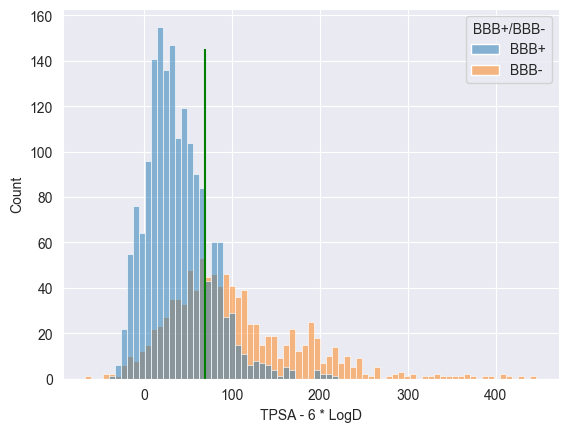

In [28]:
#ind = lambda x: (1.8 - x.desc2D_TPSA / 40 + x.chemaxon_logd / 8)
ind = lambda x: x.desc2D_TPSA - 6 * x.chemaxon_logd
threshold = 70
print("Derived, simplified index results.")
print("Train:")
print("  balanced accuracy:", balanced_accuracy_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: ind(x) < threshold)))
print("  ROC AUC:", roc_auc_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: -ind(x))))
print("  PR AUC:", pr_auc_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: -ind(x))))
print("Test:")
print("  balanced accuracy:", balanced_accuracy_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: ind(x) < threshold)))
print("  ROC AUC:", roc_auc_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: -ind(x))))
print("  PR AUC:", pr_auc_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: -ind(x))))

_df = df_train.copy()
_df["ind"] = _df.apply(axis=1, func=ind)

ax = sns.histplot(_df, x="ind", hue="BBB+/BBB-", bins=75)
ax.set_xlabel("TPSA - 6 * LogD")
_ = ax.vlines(x=threshold, ymin=0, ymax=145, colors='green')

In [29]:
_features = SIMPLE_FILTERED_FEATURES
df_feature_ffs_log_reg_simple = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42, solver="liblinear"), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    n_feat=12
)
df_feature_ffs_log_reg_simple

,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.692725,[desc2D_TPSA]
1,LogisticRegression,2,0.715577,"[desc2D_TPSA, desc2D_SPS]"
2,LogisticRegression,3,0.719012,"[desc2D_TPSA, chemaxon_logd, desc2D_SPS]"
3,LogisticRegression,4,0.725997,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
4,LogisticRegression,5,0.730848,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."
5,LogisticRegression,6,0.731947,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."
6,LogisticRegression,7,0.733693,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."
7,LogisticRegression,8,0.734283,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."
8,LogisticRegression,9,0.734283,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."
9,LogisticRegression,10,0.735224,"[desc2D_TPSA, desc2D_NumHDonors, desc2D_MolWt,..."


In [34]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "chemaxon_logd", "desc2D_SPS"]#,"desc2D_NumAromaticRings"] #, "desc2D_NumHDonors"]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.0249685   0.11367525  0.01754655]] [1.81964016]
Train balanced accuracy: 0.7187176048969971
Test balanced accuracy: 0.7288114158042283


In [31]:
_features = EXTENDED_FILTERED_FEATURES
df_feature_ffs_log_reg_extended = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42, solver="liblinear"), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    n_feat=12
)
df_feature_ffs_log_reg_extended

KeyboardInterrupt: 

In [36]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "desc2D_VSA_EState3", "desc2D_fr_ketone_Topliss"]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.0241796  -0.02698996  0.96170882]] [2.43213344]
Train balanced accuracy: 0.7249407718302406
Test balanced accuracy: 0.6990388466159392


In [37]:
print("Results for the inclusion of MACCS, discarded due to poorer interpretability of the results.")
_features = EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)
df_feature_ffs_log_reg_extended_maccs = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"],  
    n_feat=5
)
df_feature_ffs_log_reg_extended_maccs

Results for the inclusion of MACCS, discarded due to poorer interpretability of the results.


,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.692725,[desc2D_TPSA]
1,LogisticRegression,2,0.723705,"[desc2D_TPSA, maccs_fp_26]"
2,LogisticRegression,3,0.735497,"[desc2D_TPSA, desc2D_fr_quatN, maccs_fp_26]"
3,LogisticRegression,4,0.737595,"[desc2D_TPSA, desc2D_VSA_EState3, desc2D_fr_qu..."
4,LogisticRegression,5,0.750329,"[desc2D_TPSA, desc2D_VSA_EState3, desc2D_fr_qu..."


In [24]:
# df_feature_ffs_rf = get_forward_selected_feature_model_performance(
#     model_creator=lambda: RandomForestClassifier(random_state=42), 
#     X_train= df_train_features_desc2D_chemaxon_filtered, 
#     y_train=df_train["BBB_numeric"], 
#     X_test=df_test, 
#     y_test=df_test["BBB_numeric"], 
#     n_feat=25
# )
# df_feature_ffs_rf

In [25]:
# We have investigated if removal of potential outliers has an effect on the results and helps with overfitting. We have not identified any improvement in the algorithm - feature space screening. 
# from sklearn.ensemble import IsolationForest
# iso_forest = IsolationForest(contamination=0.01)
# iso_forest.fit(df_train_features)
# outlier_predictions = iso_forest.predict(df_train_features)
# df_train_pruned = df_train.loc[outlier_predictions == 1]
# print(f"Removed {len(df_train) - len(df_train_pruned)} (out of {len(df_train)} ) training samples based on IsolationForest")

# Performance of algorithms

In [32]:
_results = []
for m in [
  #  LogisticRegression(max_iter=1000, random_state=42, solver="liblinear"),
    XGBClassifier(random_state=42),
   # RandomForestClassifier(random_state=42),
]:
    for _fsn, _feats in [
        ("CNS MPO", CNS_MPO_FEATURES),
        ("2D Simple", SIMPLE_FILTERED_FEATURES),
        ("2D Extended", EXTENDED_FILTERED_FEATURES),
        ("MACCS", list(df_train_features_maccs)),
        ("ECFP-count", list(df_train_features_ecfp_count)),
        ("2D Simple + MACCS", SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS + ECFP-count", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs) + list(df_train_features_ecfp_count)),
    ]:
        _r_tr = evaluate_train(copy.deepcopy(m), df_train[_feats], df_train.murcko_scaffold_grouped, df_train["BBB_numeric"])
        _r_te = evaluate_test(
            copy.deepcopy(m).fit(df_train[_feats], df_train["BBB_numeric"]), 
            X_test=df_test[_feats],
            y_test=df_test["BBB_numeric"]
        )
        
        # _r_trp = evaluate_train(copy.deepcopy(m), df_train_pruned[_feats], df_train_pruned.murcko_scaffold_grouped, df_train_pruned["BBB_numeric"])
        # _r_tep = evaluate_test(copy.deepcopy(m).fit(df_train_pruned[_feats], df_train_pruned["BBB_numeric"]), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        _results.append({
            "model": m.__class__.__name__,
            "feature_set": _fsn,
            "train_roc_auc": sum(_r_tr["test_roc_auc"]) / len(_r_tr["test_roc_auc"]),
            "train_b_acc": sum(_r_tr["test_balanced_accuracy"]) / len(_r_tr["test_balanced_accuracy"]),
            "test_roc_auc": _r_te["roc_auc"],
            "test_pr_auc": _r_te["pr_auc"],
            "test_b_acc": _r_te["balanced_accuracy"],
            #"raw_train_roc_auc": _r_tr["test_roc_auc"],
            #"raw_train_b_acc": _r_tr["test_balanced_accuracy"],
            # "pruned_train_roc_auc": sum(_r_trp["test_roc_auc"]) / len(_r_trp["test_roc_auc"]),
            # "pruned_train_b_acc": sum(_r_trp["test_balanced_accuracy"]) / len(_r_trp["test_balanced_accuracy"]),
            # "pruned_test_roc_auc": _r_tep["roc_auc"],
            # "pruned_test_b_acc": _r_tep["balanced_accuracy"],
        })
        
df_algo_results = pd.DataFrame(_results)
df_algo_results


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/Library/Framewo

,model,feature_set,train_roc_auc,train_b_acc,test_roc_auc,test_pr_auc,test_b_acc
0,XGBClassifier,CNS MPO,0.870711,0.782856,0.819520,0.870532,0.734587
1,XGBClassifier,2D Simple,0.908556,0.812161,0.880667,0.911772,0.789158
2,XGBClassifier,2D Extended,0.919231,0.833343,0.897456,0.934534,0.798537
3,XGBClassifier,MACCS,0.908736,0.820269,0.902483,0.938615,0.823393
4,XGBClassifier,ECFP-count,0.906394,0.813600,0.903590,0.942901,0.802126
5,XGBClassifier,2D Simple + MACCS,0.916389,0.827623,0.906193,0.934684,0.809361
6,XGBClassifier,2D Extended + MACCS,0.922266,0.837309,0.898942,0.932652,0.805962
7,XGBClassifier,2D Extended + MACCS + ECFP-count,0.922651,0.833167,0.905054,0.945596,0.809171


/var/folders/h8/664cd3cn5s52nmms0vspxkj80000gn/T/ipykernel_76713/2391783578.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if value == col_max[j]:


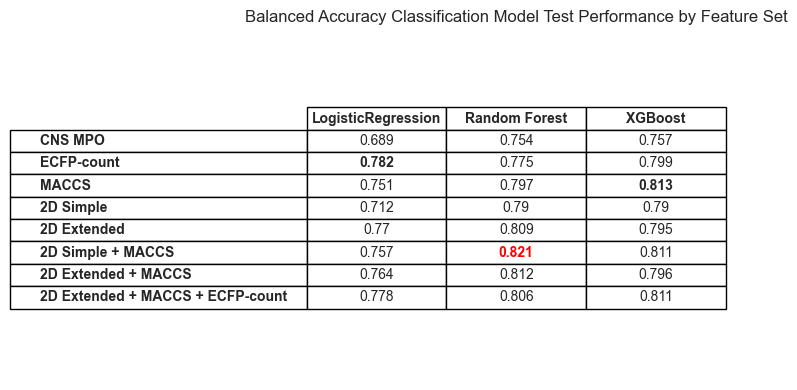

In [39]:
_feature_index = ['CNS MPO', 'ECFP-count', "MACCS", "2D Simple", "2D Extended", "2D Simple + MACCS",  "2D Extended + MACCS", "2D Extended + MACCS + ECFP-count"]
pivot_df = df_algo_results.pivot(index='feature_set', columns='model', values='test_b_acc')
pivot_df = pivot_df.reindex(index=_feature_index).rename(columns={"RandomForestClassifier": "Random Forest", "XGBClassifier": "XGBoost"})

# Identify the highest values
column_max = pivot_df.max(axis=0)  # Max value in each column
overall_max = pivot_df.max().max()  # Overall max value

# Function to render the table as a figure
def render_table_as_figure(dataframe, col_max, overall_max, title):
    # Create a figure and axis with controlled size to avoid scaling issues
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size as needed
    ax.axis('off')  # Turn off the axis

    # Create a matplotlib table
    table = ax.table(
        cellText=dataframe.values.round(3),  # Round values for better presentation
        rowLabels=dataframe.index,
        colLabels=dataframe.columns,
        cellLoc='center',
        loc='center'
    )

    # Set font size for the table and control dimensions
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Scale the table cells

    # Iterate over each cell to apply custom formatting
    for (i, j), cell in table.get_celld().items():
        # Skip formatting for header cells
        if i == 0 or j == -1:
            cell.set_fontsize(10)
            cell.set_text_props(weight='bold')
            continue
        
        # Access the value at the current cell
        value = dataframe.iloc[i - 1, j]  # Adjust indexing since headers affect it

        # Bold the highest value in each column
        if value == col_max[j]:
            cell.set_text_props(weight='bold')
        
        # Underline the overall max value by setting a different color
        if value == overall_max:
            cell.set_text_props(weight='bold', color='red')  # Highlight the overall max with bold red

    # Display the figure
    plt.title(title, pad=10)
    plt.tight_layout()
    plt.show()

# Render the table as a figure
render_table_as_figure(pivot_df, column_max, overall_max, title="Balanced Accuracy Classification Model Test Performance by Feature Set")

## Effects of Synthetic Minority Oversampling Technique (SMOTE) 
We oversample BBB- class entries to balance the datasets. 

In [8]:
_results_smote = []
for m in [
    LogisticRegression(max_iter=1000, random_state=42, solver="liblinear"),
    XGBClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    #GaussianProcessClassifier(n_jobs=-1, random_state=42)
]:
    for _fsn, _feats in [
        ("CNS MPO", CNS_MPO_FEATURES),
        ("2D Simple", SIMPLE_FILTERED_FEATURES),
        ("2D Extended", EXTENDED_FILTERED_FEATURES),
        ("MACCS", list(df_train_features_maccs)),
        ("ECFP-count", list(df_train_features_ecfp_count)),
        ("2D Simple + MACCS", SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS + ECFP-count", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs) + list(df_train_features_ecfp_count)),
    ]:  
        
        _r_tr = evaluate_train(copy.deepcopy(m), df_train[_feats], df_train.murcko_scaffold_grouped, df_train["BBB_numeric"])
        
        # We are getting somewhat changed but not considerably improved results when using SMOTE or SVMSMOTE for oversampling.
        sm = SMOTE(random_state=42)
        X_os, y_os = sm.fit_resample(df_train[_feats], df_train["BBB_numeric"])
        _r_te = evaluate_test(copy.deepcopy(m).fit(X_os, y_os), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        
        # Using a scaler degrades testing results (easily possible with boosted models, but this issue includes regression).
        #scaler = StandardScaler()
        #scaler.fit(df_train[_feats])
        
        
        # _r_trp = evaluate_train(copy.deepcopy(m), df_train_pruned[_feats], df_train_pruned.murcko_scaffold_grouped, df_train_pruned["BBB_numeric"])
        # _r_tep = evaluate_test(copy.deepcopy(m).fit(df_train_pruned[_feats], df_train_pruned["BBB_numeric"]), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        _results_smote.append({
            "model": m.__class__.__name__,
            "feature_set": _fsn,
            "train_roc_auc": sum(_r_tr["test_roc_auc"]) / len(_r_tr["test_roc_auc"]),
            "train_b_acc": sum(_r_tr["test_balanced_accuracy"]) / len(_r_tr["test_balanced_accuracy"]),
            "test_roc_auc": _r_te["roc_auc"],
            "test_b_acc": _r_te["balanced_accuracy"],
            "test_pr_auc": _r_te["pr_auc"],
            #"raw_train_roc_auc": _r_tr["test_roc_auc"],
            #"raw_train_b_acc": _r_tr["test_balanced_accuracy"],
            # "pruned_train_roc_auc": sum(_r_trp["test_roc_auc"]) / len(_r_trp["test_roc_auc"]),
            # "pruned_train_b_acc": sum(_r_trp["test_balanced_accuracy"]) / len(_r_trp["test_balanced_accuracy"]),
            # "pruned_test_roc_auc": _r_tep["roc_auc"],
            # "pruned_test_b_acc": _r_tep["balanced_accuracy"],
        })
        
df_algo_results_smote = pd.DataFrame(_results_smote)
df_algo_results_smote


KeyboardInterrupt: 

/var/folders/h8/664cd3cn5s52nmms0vspxkj80000gn/T/ipykernel_76713/2391783578.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if value == col_max[j]:


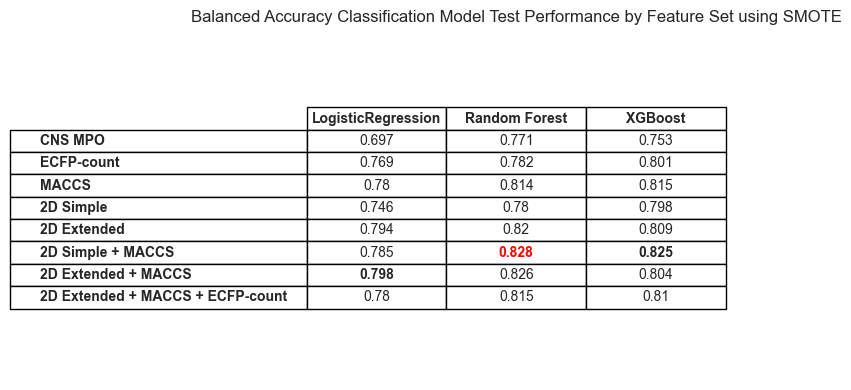

In [41]:
pivot_df = df_algo_results_smote.pivot(index='feature_set', columns='model', values='test_b_acc')
pivot_df = pivot_df.reindex(index=_feature_index).rename(columns={"RandomForestClassifier": "Random Forest", "XGBClassifier": "XGBoost"})

column_max = pivot_df.max(axis=0)  # Max value in each column
overall_max = pivot_df.max().max()  # Overall max value

render_table_as_figure(pivot_df, column_max, overall_max, "Balanced Accuracy Classification Model Test Performance by Feature Set using SMOTE")

## RandomForest classifier - development

In [7]:
features = SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs) 

In [8]:
g_scaffold_desc_for_split_mean = df_train[features + ["murcko_scaffold_grouped"]].groupby("murcko_scaffold_grouped").mean()
_s_validation_scaffolds = set(g_scaffold_desc_for_split_mean.index[twinning.twin(g_scaffold_desc_for_split_mean.to_numpy(), r=5, u1=42)])
print(f"{len(_s_validation_scaffolds)}/{len(g_scaffold_desc_for_split_mean)} (grouped) Murcko scaffolds assigned to the validation set.")

df_train_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x in _s_validation_scaffolds)]
df_train_no_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x not in _s_validation_scaffolds)]
print(f"Training set is separated into a dedicated validation (N={len(df_train_validation)}), with the remaining datapoints in training no validation set (N={len(df_train_no_validation)}) ")

337/1682 (grouped) Murcko scaffolds assigned to the validation set.
Training set is separated into a dedicated validation (N=519), with the remaining datapoints in training no validation set (N=2158) 


In [9]:
### Basic model
_model = RandomForestClassifier(random_state=42)
_model.fit(df_train_no_validation[features], df_train_no_validation["BBB_numeric"])
print("Baseline model - validation performance:")
print(evaluate_test(_model, df_train_validation[features], df_train_validation["BBB_numeric"]))

Baseline model - validation performance:
{'roc_auc': 0.9292215944758319, 'pr_auc': 0.9641468694573155, 'balanced_accuracy': 0.8346714243235207, 'accuracy': 0.859344894026975}


Model with SMOTE - validation performance:
{'roc_auc': 0.9310965738262793, 'pr_auc': 0.9651001883466582, 'balanced_accuracy': 0.8428486470413321, 'accuracy': 0.859344894026975}
desc2D_TPSA                        0.043410
chemaxon_logd                      0.037394
maccs_fp_146                       0.035670
desc2D_NumHDonors                  0.030271
chemaxon_logp                      0.029515
maccs_fp_131                       0.028257
desc2D_qed                         0.026041
maccs_fp_139                       0.024785
desc2D_MinEStateIndex              0.024783
maccs_fp_140                       0.024474
desc2D_MaxPartialCharge            0.019682
desc2D_HallKierAlpha               0.019544
desc2D_Kappa3                      0.019502
desc2D_MolWt                       0.018594
desc2D_MaxAbsEStateIndex           0.018190
desc2D_SPS                         0.017128
chemaxon_pka_b                     0.017089
desc2D_HeavyAtomCount              0.016757
desc2D_MinPartialCharge        

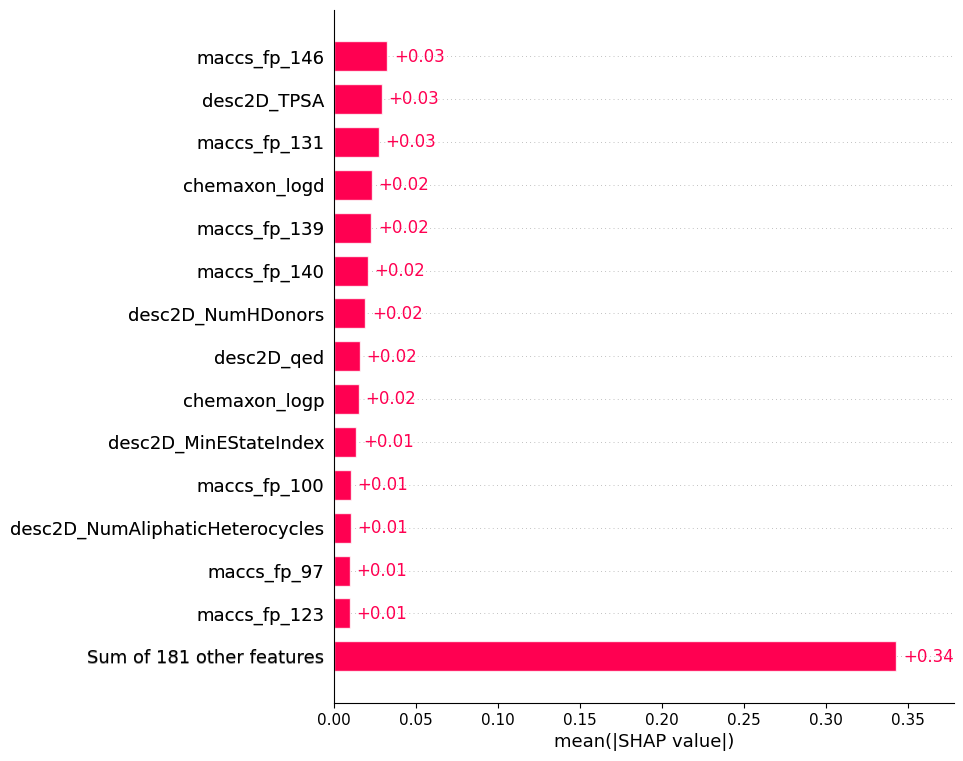

In [10]:
# X_os, y_os = sm.fit_resample(df_train[features], df_train["BBB_numeric"])

#_model.fit(X_os, y_os)
#print(evaluate_train(copy.deepcopy(_model), X_train=df_train[_fs], X_groups=df_train.murcko_scaffold_grouped, y_train=df_train.BBB_numeric))
#_model.fit(X_os, y_os)
#print(evaluate_test(_model, df_test[features], df_test["BBB_numeric"]))
_model = RandomForestClassifier(random_state=42)
sm = SMOTE(random_state=42)
X_os, y_os = sm.fit_resample(df_train_no_validation[features], df_train_no_validation["BBB_numeric"])
_model.fit(X_os, y_os)
print("Model with SMOTE - validation performance:")
print(evaluate_test(_model, df_train_validation[features], df_train_validation["BBB_numeric"]))
print(pd.Series(_model.feature_importances_, index=features).sort_values(ascending=False).head(30))

# _model = RandomForestClassifier(random_state=42)
# _model.fit(*SMOTE(random_state=42).fit_resample(df_train[features], df_train["BBB_numeric"]))
# print(evaluate_test(_model, df_test[features], df_test["BBB_numeric"]))

explainer = shap.Explainer(_model)
shap_values = explainer(df_train_validation[features])
shap.plots.bar(shap_values[:, :, 0], max_display=15)

Model with added regression results {'roc_auc': 0.932360326428123, 'pr_auc': 0.964143674719209, 'balanced_accuracy': 0.8357369412231144, 'accuracy': 0.8535645472061657}
predicted_logBB            0.053531
desc2D_TPSA                0.041756
desc2D_NumHDonors          0.039634
chemaxon_logd              0.031615
maccs_fp_146               0.029018
desc2D_qed                 0.028480
desc2D_MaxPartialCharge    0.024957
maccs_fp_139               0.022695
chemaxon_logp              0.022334
desc2D_MinEStateIndex      0.021406
dtype: float64


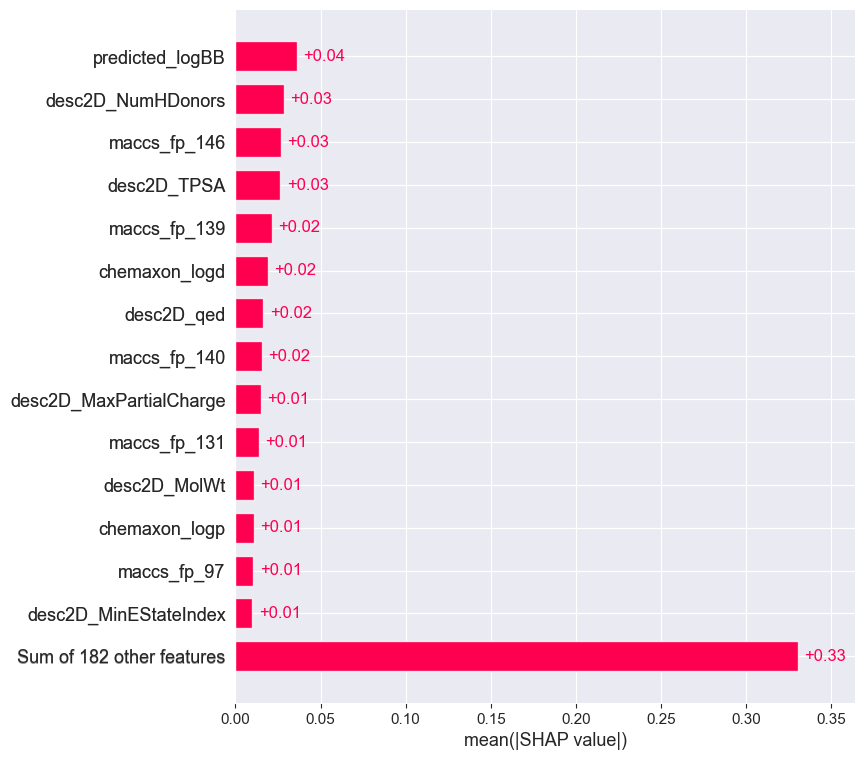

Combining regression model with R2 < 0.52 does not improve the results of Random Forest classifier. After tuning the hyperparameters and obtaining R2 of ~0.538, we can only see a marginal increase of balanced accuracy on the test set. In both cases, determined by the algorithm to be the most important feature. As it does not consistently improve the balanced accuracy of the model, we do not utilise it in the subsequent modelling efforts.


In [46]:
## This assumes the regression model is built and pickled.
with open('final_regression_model.pkl', 'rb') as file:
    m_reg = pickle.load(file)

fs_reg = [
    'desc2D_TPSA',
    'chemaxon_logp',
    'chemaxon_pka_b',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_MaxAbsPartialCharge',
]
pr_lbb = "predicted_logBB"

df_train_added_regression = df_train.copy()
df_test_added_regression = df_test.copy()

df_train_added_regression[pr_lbb] = m_reg.predict(df_train_added_regression[fs_reg])
df_test_added_regression[pr_lbb] = m_reg.predict(df_test_added_regression[fs_reg])

df_train_added_regression_validation = df_train_added_regression[df_train_added_regression.murcko_scaffold_grouped.apply(lambda x: x in _s_validation_scaffolds)]

df_train_added_regression_no_validation = df_train_added_regression[df_train_added_regression.murcko_scaffold_grouped.apply(lambda x: x not in _s_validation_scaffolds)]


_model = RandomForestClassifier(random_state=42)
sm = SMOTE(random_state=42)
_model.fit(*sm.fit_resample(df_train_added_regression_no_validation[features + ["predicted_logBB"]], df_train_added_regression_no_validation["BBB_numeric"]))
print("Model with added regression results", evaluate_test(_model, df_train_added_regression_validation[features + ["predicted_logBB"]], df_train_added_regression_validation["BBB_numeric"]))

# Test set evaluation
# _model = RandomForestClassifier(random_state=42)
# sm = SMOTE(random_state=42)
# _model.fit(*sm.fit_resample(df_train_added_regression[features + ["predicted_logBB"]], df_train_added_regression["BBB_numeric"]))
# print("Model with added regression results", evaluate_test(_model, df_test_added_regression[features + ["predicted_logBB"]], df_test_added_regression["BBB_numeric"]))


print(pd.Series(_model.feature_importances_, index=features + ["predicted_logBB"]).sort_values(ascending=False).head(10))

explainer = shap.Explainer(_model)
shap_values = explainer(df_test_added_regression[features + ["predicted_logBB"]])
shap.plots.bar(shap_values[:, :, 0], max_display=15)
print("Combining regression model with R2 < 0.52 does not improve the results of Random Forest classifier. After tuning the hyperparameters and obtaining R2 of ~0.538, we can only see a marginal increase of balanced accuracy on the test set. In both cases, determined by the algorithm to be the most important feature. As it does not consistently improve the balanced accuracy of the model, we do not utilise it in the subsequent modelling efforts.")

In [51]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 5, 80)
    
    # min_samples_split, min_samples_leaf, max_features, and criterion optimisation did not yield improvement against default parameters.
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    model.fit(df_train_no_validation[features], df_train_no_validation.BBB_numeric)
    y_pred = model.predict(df_train_validation[features])

    score = balanced_accuracy_score(df_train_validation.BBB_numeric, y_pred)
    
    return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

# Print the best parameters found 
print("Best trial:")
trial = study.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
 
_model = RandomForestClassifier(**trial.params | {"random_state": 42})
_model.fit(df_train_no_validation[features], df_train_no_validation["BBB_numeric"])
print("Optimised model - validation performance:")
print(evaluate_test(_model, df_train_validation[features], df_train_validation["BBB_numeric"]))

[I 2024-09-27 10:08:17,476] A new study created in memory with name: no-name-9da7842c-150d-4540-8ecb-824133b7b2c1
[I 2024-09-27 10:08:17,830] Trial 0 finished with value: 0.8375954009317078 and parameters: {'n_estimators': 125, 'max_depth': 77}. Best is trial 0 with value: 0.8375954009317078.
[I 2024-09-27 10:08:18,393] Trial 1 finished with value: 0.843245118445832 and parameters: {'n_estimators': 197, 'max_depth': 50}. Best is trial 1 with value: 0.843245118445832.
[I 2024-09-27 10:08:18,599] Trial 2 finished with value: 0.8246357418971157 and parameters: {'n_estimators': 81, 'max_depth': 16}. Best is trial 1 with value: 0.843245118445832.
[I 2024-09-27 10:08:18,751] Trial 3 finished with value: 0.8289225889582714 and parameters: {'n_estimators': 61, 'max_depth': 70}. Best is trial 1 with value: 0.843245118445832.
[I 2024-09-27 10:08:19,181] Trial 4 finished with value: 0.83048369511349 and parameters: {'n_estimators': 170, 'max_depth': 58}. Best is trial 1 with value: 0.843245118445

Best trial:
Value: 0.8461
Params: 
    n_estimators: 86
    max_depth: 18
Optimised model - validation performance:
{'roc_auc': 0.9304688274358213, 'pr_auc': 0.964336343162599, 'balanced_accuracy': 0.8460699772028942, 'accuracy': 0.8689788053949904}


In [53]:
sm = SMOTE(random_state=42)
X_os, y_os = sm.fit_resample(df_train_no_validation[features], df_train_no_validation["BBB_numeric"])

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 5, 80)
    
    # similarly to non-SMOTE model min_samples_split, min_samples_leaf, max_features, and criterion optimisation did not yield improvement against default parameters.
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    model.fit(X_os, y_os)
    y_pred = model.predict(df_train_validation[features])

    score = balanced_accuracy_score(df_train_validation.BBB_numeric, y_pred)
    
    return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

# Print the best parameters found 
print("Best trial:")
trial = study.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
 
_model = RandomForestClassifier(**trial.params | {"random_state": 42})
_model.fit(X_os, y_os)
print("Optimised model - validation performance:")
print(evaluate_test(_model, df_train_validation[features], df_train_validation["BBB_numeric"]))

[I 2024-09-27 10:09:44,580] A new study created in memory with name: no-name-78fd6284-14ef-4c9c-a735-3d41556b6817
[I 2024-09-27 10:09:45,003] Trial 0 finished with value: 0.8415848944394886 and parameters: {'n_estimators': 125, 'max_depth': 77}. Best is trial 0 with value: 0.8415848944394886.
[I 2024-09-27 10:09:45,643] Trial 1 finished with value: 0.8359351769253642 and parameters: {'n_estimators': 197, 'max_depth': 50}. Best is trial 0 with value: 0.8415848944394886.
[I 2024-09-27 10:09:45,911] Trial 2 finished with value: 0.8444097531965506 and parameters: {'n_estimators': 81, 'max_depth': 16}. Best is trial 2 with value: 0.8444097531965506.
[I 2024-09-27 10:09:46,114] Trial 3 finished with value: 0.8413866587372386 and parameters: {'n_estimators': 61, 'max_depth': 70}. Best is trial 2 with value: 0.8444097531965506.
[I 2024-09-27 10:09:46,669] Trial 4 finished with value: 0.8344731886212706 and parameters: {'n_estimators': 170, 'max_depth': 58}. Best is trial 2 with value: 0.844409

Best trial:
Value: 0.8501
Params: 
    n_estimators: 172
    max_depth: 17
Optimised model - validation performance:
{'roc_auc': 0.9340370700763208, 'pr_auc': 0.9665106838535296, 'balanced_accuracy': 0.850059470710675, 'accuracy': 0.8670520231213873}


In [11]:
_model = RandomForestClassifier(**{"max_depth": 17, "n_estimators": 170, "random_state": 42})
_model.fit(*SMOTE(random_state=42).fit_resample(df_train[features], df_train["BBB_numeric"]))
print("Optimised model - test performance:")
print(evaluate_test(_model, df_test[features], df_test["BBB_numeric"]))

Optimised model - test performance:
{'roc_auc': 0.9178593259279556, 'pr_auc': 0.9510079305907775, 'balanced_accuracy': 0.8303806673271084, 'accuracy': 0.8558139534883721}


In [13]:
print(
    """
    Evaluation of TabPFN as per:
    https://www.nature.com/articles/s41586-024-08328-6
    """
)
from tabpfn import TabPFNClassifier
_tabpfn = TabPFNClassifier(fit_mode="low_memory")

_tabpfn.fit(*SMOTE(random_state=42).fit_resample(df_train[features], df_train["BBB_numeric"]))
print("TabPFNClassifier - test performance:")
#print(evaluate_test(_tabpfn, df_test[features].tail(100), df_test["BBB_numeric"].tail(100)))
print("(As run on Colab:) {'roc_auc': 0.9052599962059735, 'pr_auc': 0.940668510285661, 'balanced_accuracy': 0.825975380983496, 'accuracy': 0.8527131782945736}")

TabPFNClassifier - test performance:
(As run on Colab:) {'roc_auc': 0.9052599962059735, 'pr_auc': 0.940668510285661, 'balanced_accuracy': 0.825975380983496, 'accuracy': 0.8527131782945736}


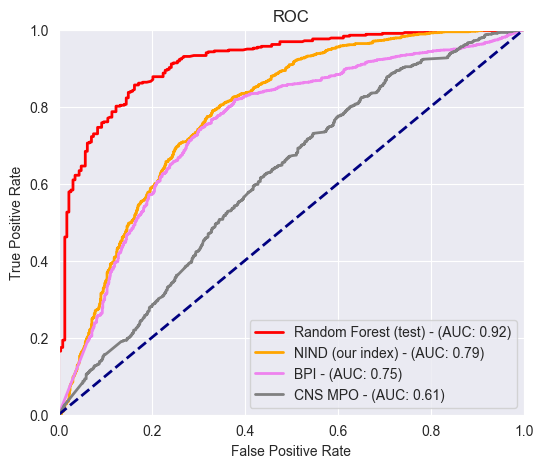

In [85]:
y_true = df_train["BBB_numeric"]  
_y_test_class_probs = _model.predict_proba(df_test[features])[:, 1] 

plt.figure(figsize=(6, 5))

fpr_xgb, tpr_xgb, thresholds_xgd = roc_curve(df_test["BBB_numeric"], _y_test_class_probs)
plt.plot(fpr_xgb, tpr_xgb, color="red", lw=2, label="Random Forest (test) - (AUC: %.2f)" % roc_auc_score(df_test["BBB_numeric"], _y_test_class_probs))

y_scores_nind = df_train.apply(axis=1, func=lambda x: x.desc2D_TPSA - 6 * x.chemaxon_logd)
fpr_nind, tpr_nind, thresholds_nind = roc_curve(y_true, -y_scores_nind)
plt.plot(fpr_nind, tpr_nind, color="orange", lw=2, label="NIND (our index) - (AUC: %.2f)" % roc_auc_score(y_true, -y_scores_nind))

y_scores_bpi = df_train.apply(axis=1, func=lambda x: calculate_balanced_permeability_index_weiss_2024(
    c_log_d=x["chemaxon_logd"], 
    psa=x["desc2D_TPSA"] if x["desc2D_TPSA"] >= 3.24  else 3.24,  # 3.24 is the lowest value above 0. 
    hac=x["desc2D_HeavyAtomCount"]) 
).apply(lambda x: -5 if x < -5 else 5 if x > 5 else x)

fpr_bpi, tpr_bpi, thresholds_bpi = roc_curve(y_true, y_scores_bpi)
plt.plot(fpr_bpi, tpr_bpi, color='violet', lw=2, label='BPI - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_bpi))

y_scores_cns_mpo = df_train.apply(axis=1, func=lambda x: calculate_cns_mpo_score_wager_2010(
    c_log_p=x.chemaxon_logp, 
    c_log_d=x.chemaxon_logd, 
    mw=x.desc2D_MolWt, 
    tpsa=x.desc2D_TPSA, 
    hbd=x.desc2D_NumHDonors, 
    pka=x.chemaxon_pka_b))  # Example scores from your function
fpr_cns_mpo, tpr_cns_mpo, thresholds_cns_mpo = roc_curve(y_true, y_scores_cns_mpo)
plt.plot(fpr_cns_mpo, tpr_cns_mpo, color='grey', lw=2, label='CNS MPO - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_cns_mpo))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [86]:
# https://pubs.acs.org/doi/10.1021/acs.jcim.1c00208
import numpy as np
from nonconformist.icp import IcpClassifier
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory
from nonconformist.acp import AggregatedCp, RandomSubSampler

def evaluate_conformal_predictor(cp_model_or_ensemble, X, y_true, significance):
    # Evaluates the performance of binary classification conformal prediction.
    mods = [cp_model_or_ensemble] if type(cp_model_or_ensemble) != list else cp_model_or_ensemble
    p_vals = []
    for mod in mods:
        p_vals.append(mod.predict(X))
    p_vals = np.mean(p_vals, axis=0)
    
    pred_0 = p_vals[:, 0] >= significance
    pred_1 = p_vals[:, 1] >= significance
    assert len(pred_0) == len(y_true), f"Mismatch between #of predicted {len(pred_0)} and true {len(y_true)}"
    efficient = pred_0 ^ pred_1  # Only values classified 
    
    validity = (sum(pred_0 & (y_true == 0)) + sum(pred_1 & (y_true == 1))) / len(y_true)
    validity_0 = sum(pred_0 & (y_true == 0)) / sum(y_true == 0)
    validity_1 = sum(pred_1 & (y_true == 1)) / sum(y_true == 1)
        
    accuracy = (sum(pred_0 & ~pred_1 & (y_true == 0)) + sum(pred_1 & ~pred_0 & (y_true == 1))) / len(y_true)
    accuracy_0 = sum(pred_0 & ~pred_1 & (y_true == 0)) / sum(y_true == 0)
    accuracy_1 = sum(pred_1 & ~pred_0 & (y_true == 1)) / sum(y_true == 1)
    
    # Is it an acceptable name?
    effective_accuracy = (sum(pred_0 & ~pred_1 & (y_true == 0)) + sum(pred_1 & ~pred_0 & (y_true == 1))) / sum(efficient) if sum(efficient) > 0 else 0
    effective_accuracy_0 = sum(pred_0 & ~pred_1 & (y_true == 0)) / sum(efficient & (y_true == 0)) if sum(efficient & (y_true == 0)) > 0 else 0
    effective_accuracy_1 = sum(pred_1 & ~pred_0 & (y_true == 1)) / sum(efficient & (y_true == 1)) if sum(efficient & (y_true == 1)) > 0 else 0 
    
    return{    
        "# pred 0": sum(pred_0),
        "# pred 1": sum(pred_1),
        "# efficient": sum(efficient),
        "# inefficient": len(y_true) - sum(efficient), 
        "efficiency": sum(efficient) / len(y_true),
        "validity": validity,
        "validity_0": validity_0,
        "validity_1": validity_1,
        "balanced_validity": (validity_0 + validity_1) / 2,
        "error": 1-validity,
        "error_0": 1- validity_0,
        "error_1": 1 - validity_1,
        "balanced_error": 1-(validity_0 + validity_1) / 2,
        "accuracy": accuracy,
        "accuracy_0": accuracy_0,
        "accuracy_1": accuracy_1,
        "balanced_accuracy": (accuracy_0 + accuracy_1) / 2,
        "effective_accuracy": effective_accuracy,
        "effective_accuracy_0": effective_accuracy_0,
        "effective_accuracy_1": effective_accuracy_1,
        "balanced_effective_accuracy": (effective_accuracy_0 + effective_accuracy_1) / 2,
    }


def plot_conformal_predictor_evaluation(_df, title, ax=None):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=[5, 4])
    efficiency_auc = auc(_df["significance"], _df["efficiency"])
    sns.lineplot(_df, x="significance", y="efficiency", ax=ax, label=f"Efficiency | AUC: {efficiency_auc:.3f}")
    
    error_auc = auc(_df["significance"], _df["error"])
    sns.lineplot(_df, x="significance", y="error", ax=ax, label=f"Error | AUC: {error_auc:.3f}")
    
    balanced_accuracy_auc = auc(_df["significance"], _df["balanced_accuracy"])
    sns.lineplot(_df, x="significance", y="balanced_accuracy", ax=ax, label=f"Balanced Accuracy | AUC: {balanced_accuracy_auc:.3f}")
    ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax.legend(loc="lower center")
    
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_xlabel("Significance")
    ax.set_ylabel("Efficiency | Error | Accuracy")
    ax.set_title(title)


In [96]:
icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
acp_aggregation_function = (lambda x: np.median(x, axis=2)) # Function to aggregate p-values in ACP

np.random.seed(22)  # This has been modified from 42 to show (which yielded better results) to exemplify the model variance and its sensitivity to initial conditions. 
acp = AggregatedCp(
    predictor=IcpClassifier(
        nc_function=NcFactory.create_nc(
            model=RandomForestClassifier(**{"max_depth": 18, "n_estimators": 90, "random_state": 42}), 
            err_func=InverseProbabilityErrFunc(), 
            normalizer_model=None
        ),
        condition=icp_classifier_condition
    ),
    sampler=RandomSubSampler(calibration_portion=0.3)
)

acp.fit(df_train_no_validation[features].to_numpy(), df_train_no_validation["BBB_numeric"].to_numpy())

acp_evaluation_validation = [{"significance": sig/100} | evaluate_conformal_predictor(acp, df_train_validation[features].to_numpy(), df_train_validation.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

acp_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

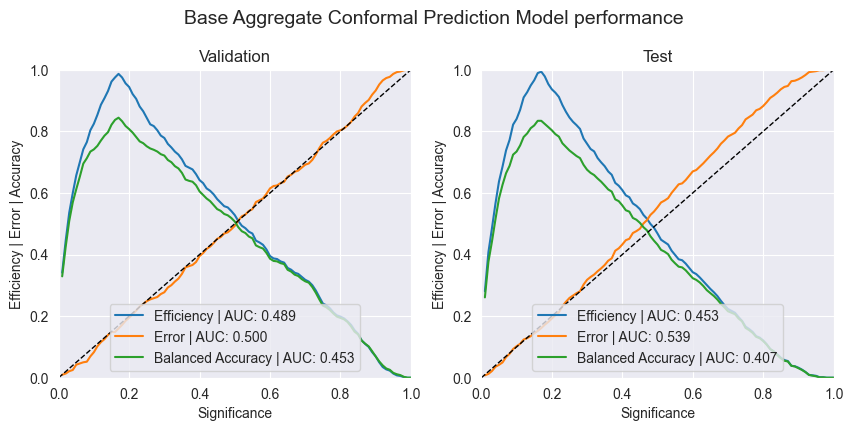

In [97]:
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

_st = plt.suptitle("Base Aggregate Conformal Prediction Model performance", fontsize=14)
_st.set_y(1.03)
plot_conformal_predictor_evaluation(pd.DataFrame(acp_evaluation_validation), title="Validation", ax=axs[0])
plot_conformal_predictor_evaluation(pd.DataFrame(acp_evaluation_test), title="Test", ax=axs[1])

# Bring it down to scientific level. Get examples. Is it the effect of hte compounds or a mathematical problem. What are the features that make us manipulate p-values.

In [99]:
from sklearn import clone
# The implementation  of this ensembl is inspired by  https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00422-x, for which the code is available at https://github.com/volkamerlab/knowtox_manuscript_SI/tree/master/notebooks
# It trains multiple averaged conformal predictors and averages p-value for each class.

# Application of conformal predictions, according to: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0325-4 (available in ChEMBL) provides different level of activities.

from sklearn.ensemble import RandomForestClassifier
from nonconformist.icp import IcpClassifier
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory
from nonconformist.acp import AggregatedCp, RandomSubSampler

_model = RandomForestClassifier(max_depth=18, n_estimators=90, random_state=42)
icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
acp_aggregation_function = (lambda x: np.median(x,axis=2))

def train_acp_cv(data_X, class_y, data_groups, acp_model_count, normaliser_model=None, acp_option=None, cv_n_splits=5):
    if acp_option is None:
        acp_option = RandomSubSampler(calibration_portion=0.3)
 
    kf = StratifiedGroupKFold(n_splits=cv_n_splits, random_state=42, shuffle=True)
    acps_cv = []
    
    for i, (train_index, test_index) in enumerate(kf.split(data_X, class_y, data_groups)):
        print(f"Fold {i}, #training: {len(train_index)}, #test {len(test_index)}")
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = class_y[train_index], class_y[test_index]
        
        mod = clone(_model)
        nc = NcFactory.create_nc(mod, err_func=InverseProbabilityErrFunc(), normalizer_model=normaliser_model)
        icp = IcpClassifier(nc, condition=icp_classifier_condition)
        acp = AggregatedCp(n_models=acp_model_count, predictor=icp, sampler=acp_option,
                           aggregation_func=acp_aggregation_function)
        acp.fit(X_train, y_train)
        
        acps_cv.append(acp)
    
    return acps_cv

np.random.seed(42)
acp_ensemble = train_acp_cv(df_train_no_validation[features].to_numpy(), df_train_no_validation["BBB_numeric"].to_numpy(), df_train_no_validation["murcko_scaffold_grouped"].to_numpy(), acp_model_count=5)

acp_ensemble_large = train_acp_cv(df_train_no_validation[features].to_numpy(), df_train_no_validation["BBB_numeric"].to_numpy(), df_train_no_validation["murcko_scaffold_grouped"].to_numpy(), acp_model_count=25)

Fold 0, #training: 1688, #test 470
Fold 1, #training: 1766, #test 392
Fold 2, #training: 1741, #test 417
Fold 3, #training: 1715, #test 443
Fold 4, #training: 1722, #test 436
Fold 0, #training: 1688, #test 470
Fold 1, #training: 1766, #test 392
Fold 2, #training: 1741, #test 417
Fold 3, #training: 1715, #test 443
Fold 4, #training: 1722, #test 436


In [100]:
acp_ensemble_evaluation_validation = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble, df_train_validation[features].to_numpy(), df_train_validation.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

acp_ensemble_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

acp_ensemble_large_evaluation_validation = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble_large, df_train_validation[features].to_numpy(), df_train_validation.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

acp_ensemble_large_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble_large, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]

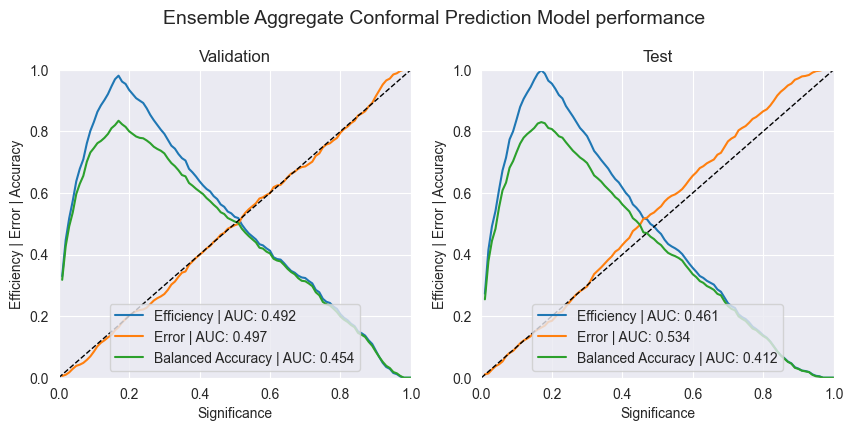

In [101]:
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

_st = plt.suptitle("Ensemble Aggregate Conformal Prediction Model performance", fontsize=14)
_st.set_y(1.03)
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_evaluation_validation), title="Validation", ax=axs[0])
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_evaluation_test), title="Test", ax=axs[1])

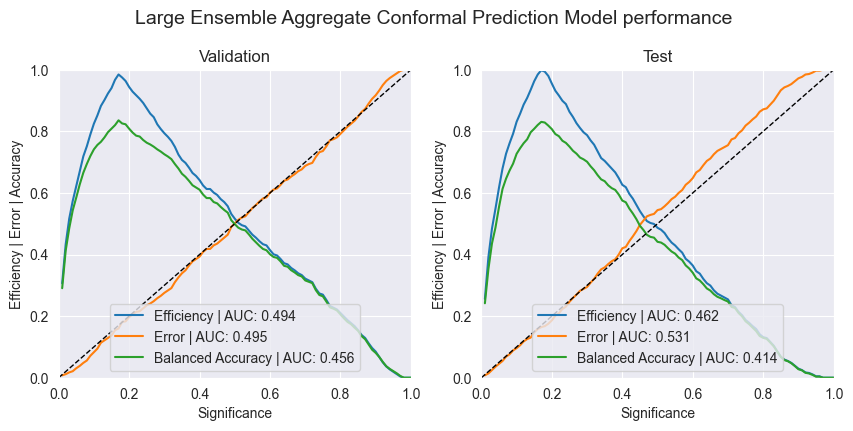

In [102]:
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

_st = plt.suptitle("Large Ensemble Aggregate Conformal Prediction Model performance", fontsize=14)
_st.set_y(1.03)
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_large_evaluation_validation), title="Validation", ax=axs[0])
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_large_evaluation_test), title="Test", ax=axs[1])
# The performance of larger ensembles of Aggregated Conformal Predictors is seemingly slightly less sensitive to initial conditions (i.e. random seed sensitivity).

Fold 0, #training: 2137, #test 540
Fold 1, #training: 2168, #test 509
Fold 2, #training: 2133, #test 544
Fold 3, #training: 2113, #test 564
Fold 4, #training: 2157, #test 520
Surprisingly, we observe a small drop in performance on the test set when extended the training/calibration dataset to include the previously withheld validation sample as the model becomes less efficient and the error increases.


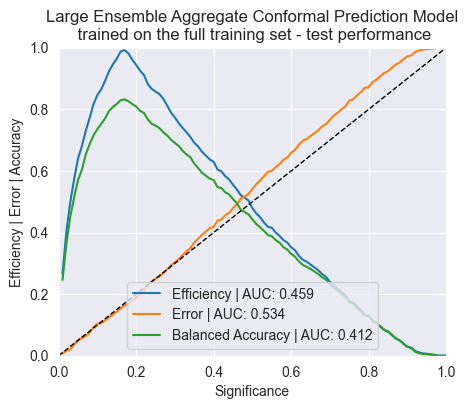

In [106]:
np.random.seed(42)
acp_ensemble_large_full_training_set = train_acp_cv(df_train[features].to_numpy(), df_train["BBB_numeric"].to_numpy(), df_train["murcko_scaffold_grouped"].to_numpy(), acp_model_count=25)
acp_ensemble_large_full_training_set_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble_large_full_training_set, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_large_full_training_set_evaluation_test), title="Large Ensemble Aggregate Conformal Prediction Model\n trained on the full training set - test performance")
print("Surprisingly, we observe a small drop in performance on the test set when extended the training/calibration dataset to include the previously withheld validation sample as the model becomes less efficient and the error increases.")

Fold 0, #training: 2141, #test 536
Fold 1, #training: 2142, #test 535
Fold 2, #training: 2141, #test 536
Fold 3, #training: 2142, #test 535
Fold 4, #training: 2142, #test 535
No improvement observed from utilising random grouping in cross validation.


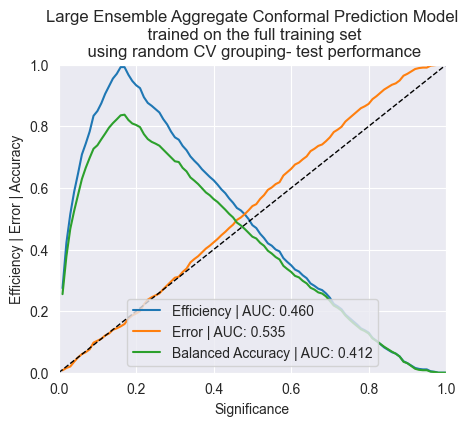

In [104]:
np.random.seed(42)
acp_ensemble_large_full_training_set_random_cv = train_acp_cv(df_train[features].to_numpy(), df_train["BBB_numeric"].to_numpy(), df_train["smiles"].to_numpy(), acp_model_count=25) # we use smiles as a group simply to avoid changing the CV StratifiedGroupedKFold interface.
acp_ensemble_large_full_training_set_random_cv_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble_large_full_training_set_random_cv, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_large_full_training_set_random_cv_evaluation_test), title="Large Ensemble Aggregate Conformal Prediction Model\n trained on the full training set\n using random CV grouping- test performance")
print("No improvement observed from utilising random grouping in cross validation.")

Fold 0, #training: 2353, #test 324
Fold 1, #training: 2420, #test 257
Fold 2, #training: 2433, #test 244
Fold 3, #training: 2356, #test 321
Fold 4, #training: 2416, #test 261
Fold 5, #training: 2418, #test 259
Fold 6, #training: 2418, #test 259
Fold 7, #training: 2402, #test 275
Fold 8, #training: 2469, #test 208
Fold 9, #training: 2408, #test 269
Increasing the number of the cross validation folds / models in the ensemble does not improve the performance.


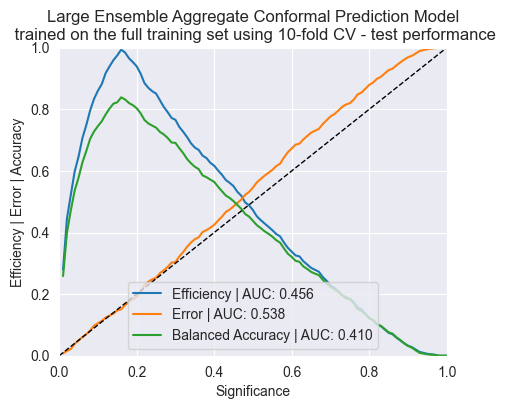

In [105]:
np.random.seed(42)
acp_ensemble_large_full_training_set_10cv = train_acp_cv(df_train[features].to_numpy(), df_train["BBB_numeric"].to_numpy(), df_train["murcko_scaffold_grouped"].to_numpy(), acp_model_count=25, cv_n_splits=10)
acp_ensemble_large_full_training_set_10cv_evaluation_test = [{"significance": sig/100} | evaluate_conformal_predictor(acp_ensemble_large_full_training_set_10cv, df_test[features].to_numpy(), df_test.BBB_numeric.to_numpy(), significance=sig/100) for sig in range(1, 101)]
plot_conformal_predictor_evaluation(pd.DataFrame(acp_ensemble_large_full_training_set_10cv_evaluation_test), title="Large Ensemble Aggregate Conformal Prediction Model\n trained on the full training set using 10-fold CV - test performance")
print("Increasing the number of the cross validation folds / models in the ensemble does not improve the performance.")